# Highlights: News Text Summarization Project

## Submitted by Shivani Naik

With human lives getting increasingly busy day by day, it is difficult to stay in touch with everything that is happening around the world. People want to stay up to date on the latest news while spending minimal time reading it. In such a scenario, reading the summary or highlights of news stories is a more convenient way to keep up with the news. Reading short summaries of all articles saves time for those who do not want to read the complete article, and if someone needs more information after reading the summary, they can read the articles that interest them.

The goal of this project is to automate the text summarizing of news stories. The system will generate a brief synopsis of approximately 60-100 words for a news article that is provided.

The process followed is:
* Preprocessing and Transformation
* EDA
* Extractive Text Summarization with Sentence Ranking
* Abstractive Text Summarization with Huggingface T5 model fine tuning
* Comparing Extractive and Abstractive Text Summarization

Given a fresh news article as input, the system will generate a text summary of it. This project will involve exploring extractive and abstractive text summarization techniques. Extractive technique generates summary using important sentences from the original text, whereas abstractive technique summarizes most important information in a new way using advanced natural language processing.  

## Data Source
The CNN / Dailymail News Dataset, which contains over 300,000 news stories and is available on both Papers with Code and Kaggle, will be used for the research.The dataset is also available as a part of the Huggingface datasets, which will be used for abstractive text summarization using T5 transformer.

Each article has the article body and a human generated summary. The dataset was collected for a question and answering system, and can also be used to create a text summarization system. 
The CNN articles collection range from April 2007 to April 2015, whereas the DailyMail articles are between June 2010 and April 2015. 

Dataset Link: https://paperswithcode.com/dataset/cnn-daily-mail-1

## Data Description
The corpus is divided into train, valid and test sets. Training set has approximately 286K articles, valid set has 13K and test set 11K articles. 

The original articles have 766 words and 29 sentences on average. The summaries for these articles have 56 words and 3.7 sentences on average. 

For every article, the dataset has:
ID: String ID of article
Article: Entire article body of ~766 words
Highlights: Summary of the article of ~56 words

This data can be used to train extractive as well as abstractive text summarization models using deep learning models.

Due to resource restrictions and huge size of model and data, I have used a subset of data for modeling experiments. The same can be done using the entire dataset when more GPU compute is available.



In [ ]:
# Install libraries
!pip install --upgrade gensim
!pip install --no-cache-dir transformers sentencepiece
!pip install datasets
!pip install evaluate
!pip install rouge_score


In [ ]:
# Import necessary libraries
import nltk
from collections import Counter
import heapq
from rouge_score import rouge_scorer
from transformers import pipeline
import gensim
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from glove import Corpus, Glove
from nltk.corpus import stopwords
from nltk.stem import  WordNetLemmatizer
import seaborn as sns
import fasttext
from gensim.models import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from gensim.models.keyedvectors import KeyedVectors
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from keras.layers.pooling import GlobalAveragePooling1D
import logging
from numpy import array
from numpy import asarray
from numpy import zeros
import fasttext
import evaluate

%matplotlib inline

In [ ]:
# Download nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

I have used Google colab for faster performance and uploaded data to drive to avoid reuploading every time runtime is recycled. Let us mount the google drive and read the dataset.

In [ ]:
# Mount data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Root directory variable, helps in decapsulating and avoiding hardcoding csv file names
root = "/content/drive/MyDrive/cnn-data/"

train_df = pd.read_csv(root+"train.csv")
validation_df = pd.read_csv(root+"validation.csv")
test_df = pd.read_csv(root+"test.csv")

# Data Understanding and EDA

The data is divided into training, validation and test sets.
* Training set: 287K articles
* Validation set: 13K articles
* Test set: 11K articles

Fields:
* ID : Unique ID of article
* Article: News article body
* Highlights: News article summary

This section will show sample articles and few data points to understand the data more.

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", validation_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (287113, 3)
Validation set shape: (13368, 3)
Test set shape: (11490, 3)


In [ ]:
# Sample data for computational purposes
train_df = train_df.sample(30000).reset_index(drop=True)

In [ ]:
# Snapshot of dataset
train_df.head()

,id,article,highlights
0,fef38572c5452c1a79af7cfba24ac0eaad40c0ba,By . Joshua Gardner . and Ap Reporter . A Cal...,"Robert Cox of Manteca, California was just pas..."
1,d222143d15cc93b65d7f76500e878a290f9b85a4,Sinister: David Russell lured his 19-year-old ...,David Russell has been jailed for life for kid...
2,cc1af28a940a9d8fe9fa2dd2f24dd9b9cc916a43,By . Victoria Woollaston . and Jonathan O'Call...,"Using modern dating techniques, .\na Cambridge..."
3,7a17330f65227aa1155ec9fab9972dd35d207612,(CNN)The first indication that something was w...,All three girls skipped school and took a flig...
4,80a774435cfe17b62d5103733378d0a94b4663d5,The Islamic State terror group has issued batt...,Terror group has published safety advise for i...


In [ ]:
#Sample article
train_df.iloc[0]['article']

"By . Mark Prigg . PUBLISHED: . 06:33 EST, 4 March 2013 . | . UPDATED: . 08:10 EST, 4 March 2013 . A real-life Instagram camera is set to go on sale after being backed by Polaroid. The camera was originally developed as a concept by designers Socialmatic. It contains a lens, touchscreen and printer - and has been designed to look like the icon for Facebook's photo sharing site. Scroll down for video . The instagram camera contain a mini printer so it can produce postcards instantly . The camera produces postcard sized prints which can easily be written on to personalise them . The product was originally designed as a concept, and uses film that has space to write, and a sticky strip on the back rather like a post-it note. However, after the designs became a hit online, the two firms have decided to turn them into a real product. The camera is set to go on sale next year, and will come with camera bags, lenses, filters and other camera accessories. 'We are so proud to work together with

In [ ]:
# Sample summary
train_df.iloc[0]['highlights']

'Camera will come with filters to recreate retro effects .\nCan print mini postcards with space to write on them .\nWill also post pictures to Facebook, Twitter and Instagram .'

In [ ]:
all_news_sample = ' '.join(train_df['article'].sample(50000)) 
len(all_news_sample)

201346505

In [ ]:
all_highlights_sample = ' '.join(train_df['highlights'].sample(50000)) 
len(all_highlights_sample)

14748524

#Preprocessing and Transformation

The data needs to be preprocessed before we can do text summarization. Depending on the type of summarization, the preprocessing steps vary. 

## Custom Preprocessor Class
All functions related to preprocessing are included in the below Preprocess class.. This will help in maintaining code, reusing it and one can also add more preprocessing functions later to the same class. 

The class implements all text cleaning functions like lowercase, stopword removal, lemmatization, sentence tokenization and word tokenization, punctuation removal etc. 

In [ ]:
class Preprocess():
  def __init__(self):
    pass
  def toLower(self, x):
    '''Converts string to lowercase'''
    return x.lower()
  
  def sentenceTokenize(self, x):
    '''Tokenizes document into sentences'''
    sent_tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
    sentences = sent_tokenizer.tokenize(x)
    return sentences
  
  def preprocess_sentences(self, all_sentences):
    '''Tokenizes sentences into words, removes punctuations, stopwords and 
    performs tokenization'''
    word_tokenizer = nltk.RegexpTokenizer(r"\w+")
    sentences = []
    special_characters = re.compile("[^A-Za-z0-9 ]")
    for s in all_sentences:
      # remove punctuation
      s = re.sub(special_characters, " ", s)
      # Word tokenize
      words = word_tokenizer.tokenize(s)
      # Remove Stopwords
      words = self.removeStopwords(words)
      # Perform lemmatization
      words = self.wordnet_lemmatize(words)
      sentences.append(words)
    return sentences

  def removeStopwords(self, sentence):
    '''Removes stopwords from a sentence'''
    stop_words = stopwords.words('english')
    tokens = [token for token in sentence if token not in stop_words]
    return tokens

  def wordnet_lemmatize(self, sentence):
    '''Lemmatizes tokens in a sentence'''
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence]
    return tokens
  
  def complete_preprocess(self, text):
    '''Performs complete preprocessing on document'''
    #Convert text to lowercase
    text_lower = self.toLower(text)
    #Sentence tokenize the document
    sentences = self.sentenceTokenize(text_lower)
    #Preprocess all sentences
    preprocessed_sentences = self.preprocess_sentences(sentences)
    return preprocessed_sentences

  def generate_wordcloud(self, text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
  
  def calculate_length(self, df):
    df["article_len"] = df["article"].apply(lambda x: len(x.split()))
    df["highlights_len"] = df["highlights"].apply(lambda x: len(x.split()))
    return df
  
  def most_similar_words(self, model, words):
    '''Returns most similar words to a list of words'''
    for word in words:
      print("Most similar to ", word,": ", model.wv.most_similar(word))
  
  def word2vec_model(self, sentences,num_feature, min_word_count, 
                    window_size, down_sampling,  sg):
    '''Creates and trains Word2Vec model'''
    num_thread = 5
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    model = word2vec.Word2Vec(sentences, 
                          #iter = iteration,
                          vector_size=num_feature, 
                          min_count = min_word_count, 
                          window = window_size, 
                          sample = down_sampling, 
                          workers=num_thread,
                          sg = sg,
                          epochs = 20)
    return model

  def glove_model(self, sentences, window_size, num_features, lr, iterations):
    '''Creates and trains GloVe model'''
    num_thread = 5
    corpus = Corpus() 
    # Create word co occurence matrix 
    corpus.fit(sentences, window=window_size)
    glove = Glove(no_components=num_features, learning_rate=lr)
    # Fit model
    glove.fit(corpus.matrix, epochs=iterations, no_threads=num_thread)
    glove.add_dictionary(corpus.dictionary)
    return glove
  
  def most_similar_words_glove(self, model, words):
    '''Returns most similar words to a list of words for GloVe model'''
    for word in words:
      print("Most similar to ", word,": ", model.most_similar(word))
  
  def top_10_frequent_words(self, model):
    '''Returns top 10 frequent words'''
    # sort model vocab according to top frequent words
    model.sorted_vocab
    top_words = model.wv.index_to_key[:10]
    return top_words


In [ ]:
# Instantiate custom preprocessor
preprocessor = Preprocess()


In [ ]:
# Instantiate DL Pipeline
dl_pipeline = DLPipeline()

## Preprocess the articles and summaries

To preprocess the data, following steps have been followed:
* Lower Case: Convert the entire text to lower case
* Sentence Tokenize: Tokenize each article into constituent sentences
* Punctuation Removal: Remove punctuation and special characters as they add noise to data
* Word Tokenize: Tokenize each sentence into words
* Stopword Removal: Remove stopwords from sentences as they will throw off the ranking algorithm for extractive summarization

Following section preprocesses all data and shows a snapshot of the preprocessed data

In [ ]:
test_df["clean_article"] = test_df['article'].apply(lambda x: preprocessor.complete_preprocess(x))
test_df["clean_highlights"] = test_df['highlights'].apply(lambda x: preprocessor.complete_preprocess(x))
test_df.head()

,id,article,highlights,clean_article,clean_highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...,"[[ever, notice, plane, seat, appear, get, smal...","[[experts, question, pack, plan, put, passenge..."
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...,"[[drink, teenage, boy, rescue, security, jump,...","[[drink, teenage, boy, climb, lion, enclosure,..."
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...,"[[dougie, freedman, verge, agree, new, two, ye...","[[nottingham, forest, close, extend, dougie, f..."
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...,"[[liverpool, target, neto, also, want, psg, cl...","[[fiorentina, goalkeeper, neto, link, liverpoo..."
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6...","[[bruce, jenner, break, silence, two, hour, in...","[[tell, interview, reality, tv, star, 69, air,..."


In [ ]:
validation_df["clean_article"] = validation_df['article'].apply(lambda x: preprocessor.complete_preprocess(x))
validation_df["clean_highlights"] = validation_df['highlights'].apply(lambda x: preprocessor.complete_preprocess(x))
validation_df.head()

In [ ]:
train_df["clean_article"] = train_df['article'].apply(lambda x: preprocessor.complete_preprocess(x))
train_df["clean_highlights"] = train_df['highlights'].apply(lambda x: preprocessor.complete_preprocess(x))
train_df.head()

## EDA Continued

After preprocessing, more exploration can be done to understand the data.
Plotting a wordcloud to see the most appearing words in the news dataset helps is seeing a pattern. 

Following wordclouds are plotted from a sample of news and higlights (100k). Both wordclouds show similar words like year, police, official, say, new etc, so both the news articles and the summaries cover similar topics. They are also the topics that mostly appear in any news articles.



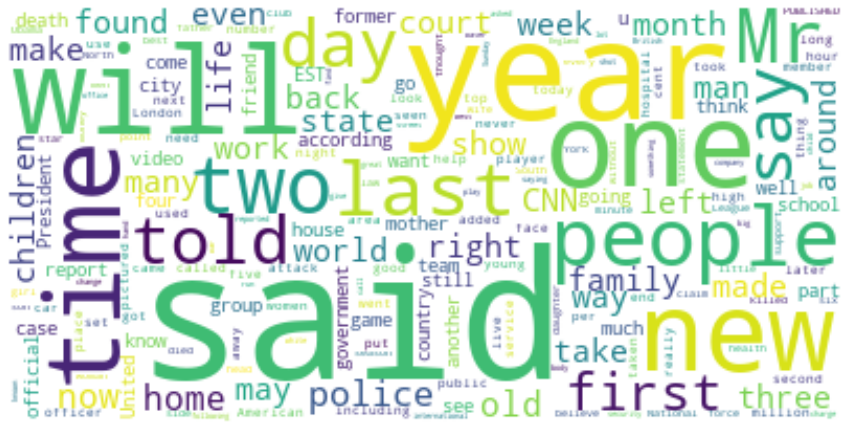

In [ ]:
preprocessor.generate_wordcloud(all_news_sample)

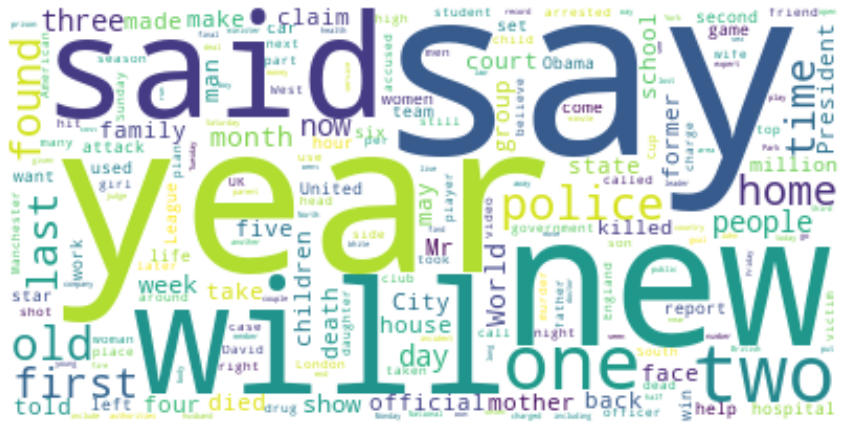

In [ ]:
preprocessor.generate_wordcloud(all_highlights_sample)

Let's look at the length of news articles and summaries.

In [ ]:
# Calculate length
train_df = preprocessor.calculate_length(train_df)
validation_df = preprocessor.calculate_length(validation_df)
test_df = preprocessor.calculate_length(test_df)


In [ ]:
# Concatenate all sets for EDA
total_df = pd.concat([train_df, validation_df, test_df])
total_df.head()

,id,article,highlights,article_len,highlights_len
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ...",198,37
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...,392,38
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t...",808,69
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...,531,53
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...,580,67


We can see, the mean length of articles is around 690 words and of the summaries is around 52 words.
The max length of an article is 2347 words and of summaries is 1440 words

In [ ]:
total_df[['article_len','highlights_len']].describe()

,article_len,highlights_len
count,311971.000000,311971.000000
mean,690.882790,51.972119
std,337.268104,21.554799
min,8.000000,4.000000
25%,441.000000,38.000000
50%,630.000000,49.000000
75%,877.000000,60.000000
max,2347.000000,1440.000000


## Distribution of Article and Summary Length

The distribution of both news articles and summaries is right skewed. Mode of article length is around 500 and of summary length is around 50.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



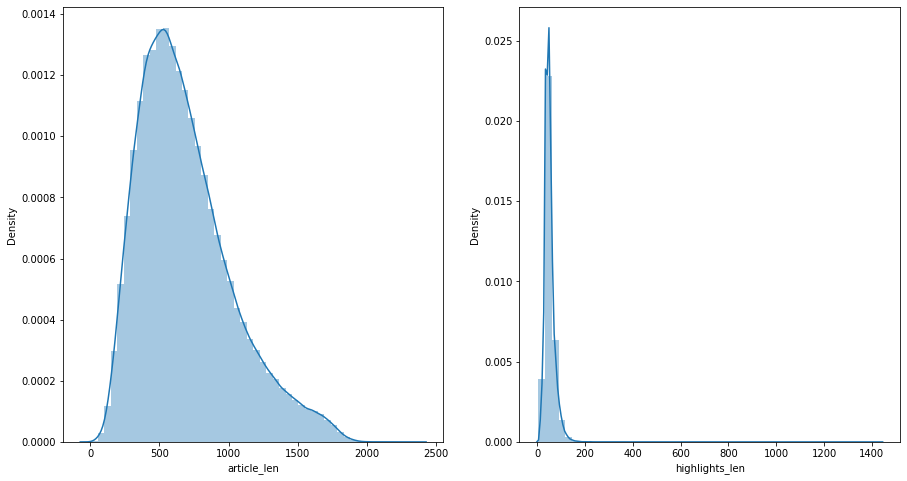

In [ ]:
# Create subplots and plot a distribution plot
fig, axes = plt.subplots(1, 2, figsize = (15,8))
sns.distplot(total_df['article_len'], ax=axes[0])
sns.distplot(total_df['highlights_len'], ax = axes[1])

Summary lengths and article lengths both have a few outliers, indicating few articles have longer length and corresponding longer summaries.

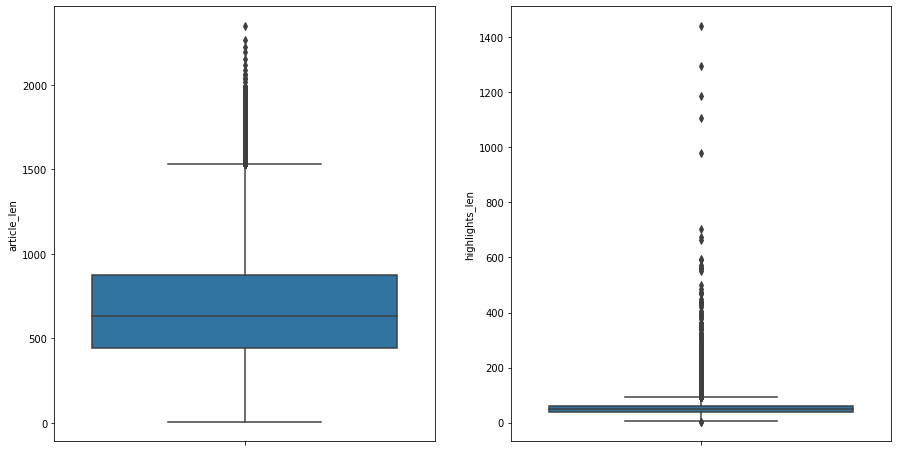

In [ ]:
# Create subplots and plot a distribution plot
fig, axes = plt.subplots(1, 2, figsize = (15,8))
sns.boxplot(data = total_df, y=total_df['article_len'], ax=axes[0])
sns.boxplot(data = total_df, y = total_df['highlights_len'],ax = axes[1])

## Extractive Summarization
* Identify most significant sentences from text and stack them to create summary​

* Uses sentence ranking algorithms​

* Time and Resource Efficient​
* Text Preprocessing:​

  * Remove stopwords​

  * Remove punctuation​

  * Convert to lowercase​

* Tokenization:​

  * Tokenize into sentence and words​

* Word Frequency:​

  * Calculate normalized word frequency for all words​

  * Normalized using maximum frequency​

* Sentence Tokenization and Ranking:​

  * Rank each sentence by adding word frequencies​

* Summary:​

  * Select Top K Sentences by Rank ​

In [ ]:
class NewsSummarization():
  def __init__(self):
    pass
  def extractive_summary(self, text, sentence_len = 8, num_sentences = 3):
    '''Generates extractive summary of num_sentences length using sentence scoring'''
    word_frequencies = {}
    # Instantiate Custom Preprocessor class
    preprocessor = Preprocess()
    # preprocess and tokenize article
    tokenized_article = preprocessor.complete_preprocess(text)
    #calculate word frequencies
    for sentence in tokenized_article:
      for word in sentence:
        if word not in word_frequencies.keys():
          word_frequencies[word] = 1
        else:
          word_frequencies[word] += 1
    #get maximum frequency for score normalisation
    maximum_frequency = max(word_frequencies.values())
    #normalize word frequency
    for word in word_frequencies.keys():
          word_frequencies[word] = (word_frequencies[word]/maximum_frequency)
    sentence_scores = {}

    # score sentences by adding word scores
    sentence_list = nltk.sent_tokenize(text)
    for sent in sentence_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) > sentence_len:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]
    # get sentences with largest sentence scores
    summary_sentences = heapq.nlargest(num_sentences, sentence_scores, key=sentence_scores.get)
    # join and get extractive summary
    summary = ' '.join(summary_sentences)
    return summary

  def get_rouge_score(self, actual_summary, generated_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(actual_summary, generated_summary)
    return scores

  def evaluate_extractive(self, dataset, metric):
    summaries = [self.extractive_summary(text) for text in dataset["article"]]
    score =  metric.compute(predictions=summaries, references=dataset["highlights"])
    rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
    rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
    return rouge_dict

  def evaluate_abstractive(self, dataset, metric, summarizer):
    summaries =  [summarizer(text, max_length = 120, min_length = 80, do_sample = False)[0]['summary_text'] for text in dataset["article"]]
    score =  metric.compute(predictions=summaries, references=dataset["highlights"])
    rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
    rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
    return rouge_dict

In [ ]:
news_summarizer = NewsSummarization()

## Check Extractive Summarization Examples
Let us check the extractive summaries generated for few articles. We can observe that the extractive summaries sometimes sound disconnected as they are based on sentence ranking.

In [ ]:
article = test_df['article'][1]
highlight = test_df['highlights'][1]
ex_summary = news_summarizer.extractive_summary(article)

In [ ]:
article

"A drunk teenage boy had to be rescued by security after jumping into a lions' enclosure at a zoo in western India. Rahul Kumar, 17, clambered over the enclosure fence at the\xa0Kamla Nehru Zoological Park in Ahmedabad, and began running towards the animals, shouting he would 'kill them'. Mr Kumar explained afterwards that he was drunk and 'thought I'd stand a good chance' against the predators. Next level drunk: Intoxicated Rahul Kumar, 17, climbed into the lions' enclosure at a zoo in Ahmedabad and began running towards the animals shouting 'Today I kill a lion!' Mr Kumar had been sitting near the enclosure when he suddenly made a dash for the lions, surprising zoo security. The intoxicated teenager ran towards the lions, shouting: 'Today I kill a lion or a lion kills me!' A zoo spokesman said: 'Guards had earlier spotted him close to the enclosure but had no idea he was planing to enter it. 'Fortunately, there are eight moats to cross before getting to where the lions usually are an

In [ ]:
ex_summary

"Brave fool: Fortunately, Mr Kumar  fell into a moat as he ran towards the lions and could be rescued by zoo security staff before reaching the animals (stock image) Kumar later explained: 'I don't really know why I did it. Next level drunk: Intoxicated Rahul Kumar, 17, climbed into the lions' enclosure at a zoo in Ahmedabad and began running towards the animals shouting 'Today I kill a lion!' Mr Kumar had been sitting near the enclosure when he suddenly made a dash for the lions, surprising zoo security. Rahul Kumar, 17, clambered over the enclosure fence at the\xa0Kamla Nehru Zoological Park in Ahmedabad, and began running towards the animals, shouting he would 'kill them'. A drunk teenage boy had to be rescued by security after jumping into a lions' enclosure at a zoo in western India."

### Check ROUGE Score for example
### About ROUGE Score
* Complex to measure text summarization performance​

* ROUGE score (Recall-Oriented Understudy for Gisting Evaluation)​

* ROUGE-N computes matching N-grams between original summary and model summary​

* Calculates Recall, Precision and F1-Score​

* Synonyms are not taken care of, may assign low ROUGE score​

* Recall is important, because we want to make sure that all important points are covered in the summary
* Precision will depend a little on input parameters of how long we want the summary to be. If we give a long summary length as input, precision might be lower as the actual summary will have a lot less ngrams than the generated summary
* Fmeasure will give a good overall estimate by combining recall and precision

In [ ]:
news_summarizer.get_rouge_score(highlight, ex_summary)

{'rouge1': Score(precision=0.2446043165467626, recall=0.9444444444444444, fmeasure=0.38857142857142857),
 'rougeL': Score(precision=0.1510791366906475, recall=0.5833333333333334, fmeasure=0.24)}

## Evaluate Extractive Summarization Technique on Test Set
We can evaluate the extractive summarizer on the test set. The summarizer achieves 28.91 ROUGE-1.

In [ ]:
rouge_score = evaluate.load("rouge")
extractive_score = news_summarizer.evaluate_extractive(test_df, rouge_score)
extractive_score

{'rouge1': 28.91, 'rouge2': 12.04, 'rougeL': 17.76, 'rougeLsum': 24.14}

# Abstractive Summarization
## Abstractive Summarization with T5 Model Finetuning and Huggingface
* Abstractive summarization understands context and rewrites summary​

* Closer to human summary generation process​

* Complex, difficult to generate fluent sentences​

* Transformer sequence-to-sequence model​

* Time consuming ​
* Resource intensive

I will be finetuning the T5 transformer model (Seq2Seq) from Huggingface. Before finetuning, let us check the pretrained summarization pipeline provided by huggingface.

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer
from transformers import pipeline
import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Huggingface provides a default summarizer that can be used on any dataset. Let us first check the default summarizer provided by the Huggingface pipeline

In [ ]:
summarizer = pipeline('summarization')

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)
https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp2ui4w3dl


Downloading:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
creating metadata file for /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
Model config BartConfig {
  "_name_or_path": "sshleifer/distilbart-cnn-12-6",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartF

Downloading:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
creating metadata file for /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
loading weights file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b336fa0b874ea92e3e22f07a7e6f8fa9da01221759c33abeb2679d6d98fe7755.585965cf7e82e4536033cd21d76c486af3d6b1c2a34b3a847840d4e7fe9d8844
All model checkpoint weights were used when initializing BartForConditionalGeneration.

All the weights of BartForConditionalGeneration were initialized from the model checkpoint at sshleifer/distilbart-cnn-12-6.
If your task is similar to the ta

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f5316f64f9716436994a7ad76a354dc20ecb2dd74eb61d278f103a9c8b80291f.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8
creating metadata file for /root/.cache/huggingface/transformers/f5316f64f9716436994a7ad76a354dc20ecb2dd74eb61d278f103a9c8b80291f.67d01b18f2079bd75eac0b2f2e7235768c7f26bd728e7a855a1c5acae01a91a8
loading configuration file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/adac95cf641be69365b3dd7fe00d4114b3c7c77fb0572931db31a92d4995053b.a50597c2c8b540e8d07e03ca4d58bf615a365f134fb10ca988f4f67881789178
Model config BartConfig {
  "_name_or_path": "sshleifer/distilbart-cnn-12-6",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [


Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
creating metadata file for /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpmr46fqlg


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/9951e68693b9a7c583ae677e9cb53c02715d9bd0311a78706401372653cdea0a.647b4548b6d9ea817e82e7a9231a320231a1c9ea24053cc9e758f3fe68216f05
loading file https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/7588c8d398d659b230a038240cc023f67b6848117d2999f06ab625af7bfc7ec1.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c811577

In [ ]:
article = '''The President doled out fist bumps and pats on the shoulder to the delegation stationed along the red carpet at the foot of Air Force One, which the White House said was part of an effort to reduce physical contact amid the rapid spread of a new coronavirus variant.
But only minutes later, Biden broke with the new effort -- exchanging a hearty handshake with the former Israeli Prime Minister Benjamin Netanyahu, the current opposition leader. Biden later also clasped hands with a pair of Holocaust survivors at Yad Vashem.
The President's half-hearted effort to reduce physical contact on his trip to the Middle East was a jolting switch for Biden, who has been shaking plenty of hands in the days leading up to his trip. And it raised questions about whether the White House was trying to avoid the optics of Biden shaking hands with Saudi Arabia's Crown Prince Mohammad bin Salman, whom Biden will meet for the first time on Friday.
Biden has been facing questions about that meeting after saying as a candidate he would make Saudi Arabia a "pariah" for the killing of journalist Jamal Khashoggi. The CIA has alleged that Khashoggi was killed in an operation approved by bin Salman.
Pressed by reporters aboard Air Force One, White House press secretary Karine Jean-Pierre denied that was the reason for the attempt at reduced physical contact.
"We are saying that we're going to try to minimize contact as much as possible. But also, there are precautions that we are taking because this is up to his doctor. BA.4, BA.5 is indeed, as we're seeing, increasing. And we want to make sure that we're taking those precautions to keep him safe and to keep all of us safe," Jean-Pierre said, referring to emerging coronavirus variants.'''


In [ ]:

summarizer(article, max_length = 120, min_length = 50, do_sample = False)

[{'summary_text': ' The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building . It was the first structure to reach a height of 300 metres . It is now taller than the Chrysler Building in New York City by 5.2 metres (17 ft) Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France .'}]

## Finetuning T5 Model

T5 is an encoder-decoder model that is a text-to-text transformer that uses teacher forcing. It has different sizes like t5-base, t5-small, t5-large etc. I have used t5-small as it takes less memory.

I will download the copy of dataset provided by Huggingface Hub. This will make it easier to structure the data in the required format (datasetdict).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail",'3.0.0')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

I will use the T5-small model from huggingface hub. It has 60 million parameters and pretrained on the C4 (Colossal Crawled Clean Corpus) dataset.

Let us set the max article length to 900 and summary length to 120, as observed from EDA

In [ ]:
model_checkpoint = "t5-small"
max_input_length = 900
max_target_length = 120

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False, model_max_length = max_input_length)

### Preprocess and Tokenize Data

I will use the tokenizer from pretrained model checkpoint.

I will set maximum article length to 900 and summary length to 120, as seen from EDA. We need to truncate larger articles so we do not exceed the model's maximum context size and as_target_tokenizer is used for this.

In [ ]:
def preprocess_function(examples):
  '''Preprocesses the data as required by huggingface transformer'''
    model_inputs = tokenizer(
        examples["article"], max_length=max_input_length, truncation=True
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["highlights"], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Let us shard the dataset to make it smaller, so the training time will reduce. Training the model with this small amount of data on Google Colab requires hours, and also gets GPU connection locked for a few days due to over use. We can retrain later with entire dataset.

In [ ]:
# Shuffle to get a random sample
dataset.shuffle()

In [ ]:
dataset_sample = dataset
dataset_sample['train'] = dataset['train'].shard(num_shards=50, index=0)
dataset_sample['validation'] = dataset['validation'].shard(num_shards=40, index=0)
dataset_sample['test'] = dataset['test'].shard(num_shards=40, index=0)
dataset_sample

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 5743
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 335
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 288
    })
})

### Tokenize data

We will use a pretrained tokenizer to tokenize the articles and summaries. Each huggingface model has it's own pre trained tokenizer. This tokenizer tokenizes our data in the format required by the model with the pre trained corpus.

The tokenized dataset includes input_ids and attention_mask.

In [ ]:
tokenized_datasets = dataset_sample.map(preprocess_function, batched=True)

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

### Loading Pretrained Model for finetuning

We will load the model from checkpoint, for fine tuning. AutoModelForSeq2SeqLM can be used as T5 is a seq2seq model. The weights are downloaded and cached.

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

## Setting up Training Arguments

Let us set up the training parameters. 
* Used batch size 8 to fit model in memory and avoid OOM issues
* Epochs: Recommended to train for 5-8 epochs to prevent overfitting. 
* Learning rate: Small learning rate, as we want to finetune and not train from scratch. Used 5.6 x e-4 after experimenting with multiple values
* Evaluation strategy: 'epoch', evaluates model after an epoch
* weight_decay: Used 0.01
* push_to_hub: Save model training files to huggingface hub, helpful as Google Colab can disconnect anytime
* predict_with_generate: True, to evaluate model after every epoch


In [ ]:

batch_size = 8
num_train_epochs = 5
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-cnn-news",
    evaluation_strategy="epoch",
    learning_rate=5.6e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

### Login to huggingface hub
We need to login to huggingface hub so we can save the trained model and files to the hub. This model can then be downloaded like any other model available on the Hub and used for summarization.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Setting up Metrics

Metric for text summarization task can get tricky. ROUGE metric ( Recall-Oriented Understudy for Gisting Evaluation) is a commonly used metric. It compares a generated summary to reference summary and calculates the overlap between them by calculating precision and recall, with F1 score of overlap.

recall = #overlap words / # words in reference summary

precision = # overlap words /  # words in generated summary

Having a high recall is often important as we want to capture the important essence of article.

We will use the ROUGE metric for evaluating the text summarization model.

In [ ]:
from datasets import load_metric

rouge_score = load_metric("rouge")

In [ ]:
def compute_metrics(eval_pred):
    '''Computes metrics that can be used while training'''
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # median scores, we get the fmeasure as percentage
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

### Data Collator
Creating a data collator and removing column names from training set. Data Collator helps in creating batches of input and padding before feeding it to the model.

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
tokenized_datasets = tokenized_datasets.remove_columns(
    dataset_sample["train"].column_names
)
# Get features for data collator
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[  301, 24796,  4170,  ...,     0,     0,     0],
        [ 5422,  9312,     6,  ...,  1340,   323,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[ 8929, 16023,  2213,  4173,  6324, 12591,    15,  2347,  3996,  1755,
           329, 13462,    38,     3,    88,  5050,   507,  2089,     3,     5,
          5209,  7556,   845,     3,    88,    65,   150,  1390,    12,  9030,
            17,   449,   112,  1723,   550,     3,     5,  6324, 12591,    15,
            31,     7,  8783,    45,   166,   874, 16023,  4852,    43,   118,
          1213,    16,  2019,  3069,     3,     5,     1,  -100,  -100,  -100,
          -100,  -100],
        [ 8480,  9540,   496,  3377,    12,    66,  7457,    23,   502,     6,
          6147,    13, 14330,    15,  2637,     3,     5, 15449,   845,   160,
           496,    19,   460,  1093,  7457,    23,    48,   215,     3,     5,
          2855,  6323,    10,  7457

## Set up Model Trainer

We will set up a model trainer from the trainer API with the defined model checkpoint, hyperparameters, data collator and metrics from the previous sections.

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/shivaniNK8/t5-small-finetuned-cnn-news into local empty directory.


## Train Model
We will use the trainer API from Huggingface Hub for training our model. Let us empty GPU cache to make sure we do not face OOM issues.

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5743
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3590


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,2.031800,1.802819,24.541500,12.090700,20.534300,23.338600
2,1.830700,1.802813,24.096500,11.636700,20.207800,22.813800
3,1.688100,1.813588,25.082200,12.650900,20.952300,23.830300
4,1.577800,1.826856,24.427100,11.844300,20.228100,23.094100
5,1.501000,1.841205,24.723100,12.292000,20.534700,23.466800


Saving model checkpoint to t5-small-finetuned-cnn-news/checkpoint-500
Configuration saved in t5-small-finetuned-cnn-news/checkpoint-500/config.json
Model weights saved in t5-small-finetuned-cnn-news/checkpoint-500/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-news/checkpoint-500/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-news/checkpoint-500/special_tokens_map.json
tokenizer config file saved in t5-small-finetuned-cnn-news/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-news/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 335
  Batch size = 8
Saving model checkpoint to t5-small-finetuned-cnn-news/checkpoint-1000
Configuration saved in t5-small-finetuned-cnn-news/checkpoint-1000/config.json
Model weights saved in t5-small-finetuned-cnn-news/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-news/checkpoint-1000/tokenizer_config.json
Special token

TrainOutput(global_step=3590, training_loss=1.7256429414563192, metrics={'train_runtime': 2549.5422, 'train_samples_per_second': 11.263, 'train_steps_per_second': 1.408, 'total_flos': 6830259802079232.0, 'train_loss': 1.7256429414563192, 'epoch': 5.0})

## Evaluate Model

Let us evaluate the model. The model has a rouge score of 24.72 on the sharded test set, which is a very good score as compared to other models for text summarisation tasks.

In [ ]:
trainer.evaluate()

Let us push the model to Huggingface hub to save the model.

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

Saving model checkpoint to t5-small-finetuned-cnn-news
Configuration saved in t5-small-finetuned-cnn-news/config.json
Model weights saved in t5-small-finetuned-cnn-news/pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-news/tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-news/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/231M [00:00<?, ?B/s]

Upload file runs/Jul19_01-47-20_f8497643ecf7/events.out.tfevents.1658198035.f8497643ecf7.70.2: 100%|##########…

Upload file runs/Jul19_01-47-20_f8497643ecf7/events.out.tfevents.1658195399.f8497643ecf7.70.0:  42%|####2     …

To https://huggingface.co/shivaniNK8/t5-small-finetuned-cnn-news
   01be532..74e01ee  main -> main

   01be532..74e01ee  main -> main

To https://huggingface.co/shivaniNK8/t5-small-finetuned-cnn-news
   74e01ee..1b1c41d  main -> main

   74e01ee..1b1c41d  main -> main



'https://huggingface.co/shivaniNK8/t5-small-finetuned-cnn-news/commit/74e01ee242716a25f4330568ea2882ed37577d5d'

## Load Trained Model

Now that we have trained a summarization model and pushed it to the Hub, we can use it like a downloadable Huggingface model by providing the model link. Let us load the pushed trained model from the Hub for use.

In [ ]:
from transformers import pipeline
hub_model_id = "shivaniNK8/t5-small-finetuned-cnn-news"
summarizer = pipeline("summarization", model=hub_model_id)

# Checking Summary Generation
Let us check the summary generated for articles from test set.

In [ ]:
def generate_summary(idx):
    '''Generates abstractive summary for an article from test set'''
    article = dataset_sample["test"][idx]["article"]
    actual_summary = dataset_sample["test"][idx]["highlights"]
    generated_summary = summarizer("summarize: "+dataset_sample["test"][idx]["article"], max_length = 100, min_length = 50, do_sample = False)[0]["summary_text"]
    print(f"\n'>>> Article: {article}'")
    print(f"\n'>>> Original Summary: {actual_summary}'")
    print(f"\n'>>> Generated Summary: {generated_summary}'")

In [ ]:
generate_summary(100)


'>>> Article: Pep Guardiola hit his critics for six as Bayern Munich trounced Porto to reach the Champions League semi-finals on Tuesday night. It was an emphatic statement of intent: the German juggernaught is steaming towards the final in Berlin on June 6. The six goals smashed past the hapless Portuguese pretenders in the quarter-final second leg at the Allianz Arena now takes Bayern's goals total for the season to a spectacular and barely believable 115. And they're not done yet, not by a long way. Bayern still have five Bundesliga matches to play as they march towards a third consecutive title, the German Cup semi-final against Borussia Dortmund on April 28, and potentially three Champions League matches, should they reach the final. If Guardiola's goalscoring machine churns them out at their current rate of 2.61 per game, that would mean an eyewatering total of 141 goals for the season. It isn't Guardiola who should be feeling the pressure - it's the rest of Europe. Here is a br

In [ ]:
generate_summary(50)


'>>> Article: Lionel Messi, Neymar and Luis Suarez is a star-studded strike force that almost every team in the world would dearly love to have, but when the going gets tough, Barcelona turn to Jeremy Mathieu and Gerard Pique. The French centre-back flung himself through the air to reach Xavi's free kick at the back post, heading home from close range, finally breaching Celta Vigo's stern defence. It was Mathieu who had opened the scoring in the El Clasico, in similar fashion. Pique, meanwhile, just a minute before Mathieu scored, had made an incredible, game-saving tackle on Celta striker Charles, to prevent him from opening the scoring. Jeremy Mathieu (right) heads home in the 73rd minute to hand Barcelona a 1-0 lead against Celta Vigo . Celta Vigo goalkeeper Alvarez Conde (right) is unable to stop the powerful header from Mathieu . Celta Vigo: Alvarez Conde, Mallo Novegil, Cabral, Fontas, Castro Otto, Hernandez, Fernandez, Krohn-Dehli (Radoja - 67'), Orellana, Larrivey (Dias de Oli

In [ ]:
article

'The President doled out fist bumps and pats on the shoulder to the delegation stationed along the red carpet at the foot of Air Force One, which the White House said was part of an effort to reduce physical contact amid the rapid spread of a new coronavirus variant.\nBut only minutes later, Biden broke with the new effort -- exchanging a hearty handshake with the former Israeli Prime Minister Benjamin Netanyahu, the current opposition leader. Biden later also clasped hands with a pair of Holocaust survivors at Yad Vashem.\nThe President\'s half-hearted effort to reduce physical contact on his trip to the Middle East was a jolting switch for Biden, who has been shaking plenty of hands in the days leading up to his trip. And it raised questions about whether the White House was trying to avoid the optics of Biden shaking hands with Saudi Arabia\'s Crown Prince Mohammad bin Salman, whom Biden will meet for the first time on Friday.\nBiden has been facing questions about that meeting afte

In [ ]:
summary = summarizer(article, max_length = 120, min_length = 80, do_sample = False)
abs_summary = summary[0]['summary_text']
abs_summary

"Biden has been shaking plenty of hands during his trip to the Middle East . He has been facing questions about the optics of Biden shaking hands with Saudi Arabia's Crown Prince Mohammad bin Salman . The White House says the effort was part of an effort to reduce physical contact amid the rapid spread of a new coronavirus variant . But only minutes later, Biden broke with the new effort ."

## Check Rouge Score for example

In [ ]:
news_summarizer.get_rouge_score(abs_summary, highlight)

{'rouge1': Score(precision=0.2558139534883721, recall=0.15942028985507245, fmeasure=0.1964285714285714),
 'rougeL': Score(precision=0.16279069767441862, recall=0.10144927536231885, fmeasure=0.125)}

Let us check another example. The summary generated captures the important details about the Eiffel Tower. We also notice the model correctly inserts "Eiffel tower" where "the tower" is present.

In [ ]:
article_2 = """The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. 
Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, 
a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. 
It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 
5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct."""
article_2

'The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side. During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft). Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.'

In [ ]:
summarizer("summarize: "+ article_2, max_length = 120, min_length = 80, do_sample = False)

[{'summary_text': 'Eiffel Tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building . It was the first structure to reach a height of 300 metres . Excluding transmitters, it is the tallest free-standing structure in France after the Millau Viaduct . During its construction, it surpassed the Washington Monument to become tallest man-made structure .'}]

In [ ]:
article_3 = """(CNN)Matthew Pottinger, who served on former President Donald Trump's 
National Security Council before resigning in the immediate aftermath of January 6, 2021, will testify publicly at Thursday's prime-time hearing held by the House select committee investigating the US Capitol attack, according to multiple sources familiar with the plans.

Pottinger is slated to appear alongside former Trump White House aide Sarah Matthews.
CNN previously reported that Matthews, who served as deputy press secretary in the Trump White House until resigning 
shortly after January 6, 2021, was expected to testify publicly. When she resigned, Matthews said she was honored to serve in 
Trump's administration but "was deeply disturbed by what I saw." She said at the time, "Our nation needs a peaceful transfer of power."
Pottinger, Trump's deputy national security adviser, stepped down in response to Trump's reaction to his supporters breaching 
the US Capitol, a person close to Pottinger confirmed to CNN at the time of his resignation. He told people there was very little for him to consider, 
the person said at the time.

"""
article_3

'(CNN)Matthew Pottinger, who served on former President Donald Trump\'s \nNational Security Council before resigning in the immediate aftermath of January 6, 2021, will testify publicly at Thursday\'s prime-time hearing held by the House select committee investigating the US Capitol attack, according to multiple sources familiar with the plans.\n\nPottinger is slated to appear alongside former Trump White House aide Sarah Matthews.\nCNN previously reported that Matthews, who served as deputy press secretary in the Trump White House until resigning \nshortly after January 6, 2021, was expected to testify publicly. When she resigned, Matthews said she was honored to serve in \nTrump\'s administration but "was deeply disturbed by what I saw." She said at the time, "Our nation needs a peaceful transfer of power."\nPottinger, Trump\'s deputy national security adviser, stepped down in response to Trump\'s reaction to his supporters breaching \nthe US Capitol, a person close to Pottinger conf

In the generated summary for the above article, the model got confused between Matthew Pottinger and Sarah Matthews due to similar names.

In [ ]:
summarizer("summarize: "+ article_3, max_length = 120, min_length = 80, do_sample = False)

[{'summary_text': 'Matthew Pottinger will testify at Thursday\'s prime-time hearing . She served as deputy press secretary in the Trump White House until resigning . Matthews said she was honored to serve in Trump\'s administration but was "deeply disturbed" by what I saw, sources say at the time, "Our nation needs a peaceful transfer of power"'}]

In [ ]:
article_4 = """SEATTLE — Seattle on Sunday set two new hot weather records as the high temperature of 95 degrees marked the sixth consecutive day in a row with high temperatures at 90 degrees or above.

The region also shattered the record of 94 degrees for this day that was set in 2015, according to the National Weather Service.

But the week-long heatwave is expected to come to an end Monday when the weather is expected to be noticeably cooler.
As of 2:30 p.m. Sunday, the high temperature at Seattle-Tacoma International Airport was 91 degrees before the mercury ultimately topped out at 95 degrees, besting by one degree the daily record set seven years ago.

"We have gotten there," she said about reaching the daily record milestone.
It was even hotter in interior parts of Washington with several areas logging triple-digit temperatures for the day.

Sunday marked the eighth time this summer that Seattle has seen a high temperature of 90 degrees or above and the fifth time since 2015 the region has logged a season with eight days or more above that threshold, according to local meteorologists.

The high temperature Saturday topped out at 94 degrees at SeaTac Airport, the fifth days of temperatures in the 90 range.

But a big cooling trend is on the way.
Stevenson said the high temperature Monday and Tuesday is expected to climb only to the low 80s with a bigger cool down expected Wednesday, which could also see drizzle.

The heat has taken a toll on the Pacific Northwest.

Authorities in the Portland announced that they would keep cooling shelters open through Sunday night.

At least seven people are suspected to have died from hyperthermia since the hot spell began a week ago in the Portland area
"""
article_4

'SEATTLE — Seattle on Sunday set two new hot weather records as the high temperature of 95 degrees marked the sixth consecutive day in a row with high temperatures at 90 degrees or above.\n\nThe region also shattered the record of 94 degrees for this day that was set in 2015, according to the National Weather Service.\n\nBut the week-long heatwave is expected to come to an end Monday when the weather is expected to be noticeably cooler.\nAs of 2:30 p.m. Sunday, the high temperature at Seattle-Tacoma International Airport was 91 degrees before the mercury ultimately topped out at 95 degrees, besting by one degree the daily record set seven years ago.\n\n"We have gotten there," she said about reaching the daily record milestone.\nIt was even hotter in interior parts of Washington with several areas logging triple-digit temperatures for the day.\n\nSunday marked the eighth time this summer that Seattle has seen a high temperature of 90 degrees or above and the fifth time since 2015 the re

In [ ]:
article_4_ex_summary = news_summarizer.extractive_summary(article_4)
article_4_ex_summary

'SEATTLE — Seattle on Sunday set two new hot weather records as the high temperature of 95 degrees marked the sixth consecutive day in a row with high temperatures at 90 degrees or above. As of 2:30 p.m. Sunday, the high temperature at Seattle-Tacoma International Airport was 91 degrees before the mercury ultimately topped out at 95 degrees, besting by one degree the daily record set seven years ago. Sunday marked the eighth time this summer that Seattle has seen a high temperature of 90 degrees or above and the fifth time since 2015 the region has logged a season with eight days or more above that threshold, according to local meteorologists.'

In [ ]:
article_4_abs_summary = summarizer("summarize: "+ article_4, max_length = 120, min_length = 80, do_sample = False)[0]["summary_text"]
article_4_abs_summary

"Seattle-Tacoma International Airport shattered 94 degrees for this day that was set in 2015 . But the week-long heatwave is expected to come to an end Monday . It's the eighth time this summer that Seattle has seen a high temperature of 90 degrees or above . The region has logged a season with eight days or more above that threshold ."

## Evaluate Abstractive Summarization on Test Set

In [ ]:
abstractive_score = news_summarizer.evaluate_abstractive(test_df, rouge_score, summarizer)
abstractive_score

{'rouge1': 38.74, 'rouge2': 17.24, 'rougeL': 26.73, 'rougeLsum': 32.71}

Extractive score for comparison

In [ ]:
extractive_score = news_summarizer.evaluate_extractive(test_df, rouge_score)
extractive_score

{'rouge1': 28.59, 'rouge2': 11.93, 'rougeL': 17.54, 'rougeLsum': 23.76}

## Comparing Extractive and Abstractive Technique and Conclusion

* Extractive summarizer has a ROUGE-1 score of 28.59 whereas Abstractive summarizer has a ROUGE score of 38.74. The State-of-the-art ROUGE score is 42.3
* Abstractive summaries capture more context than extractive summaries
* Extractive Summarizer is way faster than Abstractive. Generating 1 abstractive summary requires 4-5 seconds
* Abstractive summarizer has better performance for all n-grams (rouge-1, rouge-2 etc)
* Depending on the use case, either of the models can be utilised to generate a good summary of any news article